# Predicting_ActiveUsers_TimeSeries

#### Time Series Modeling: Predicting Active Users on a Web Site

#### New data

In [78]:
# Imports 
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings("ignore")

In [79]:
data = pd.read_csv('..\project_model\dataset.csv')

In [80]:
data_new = pd.read_csv("new_dataset.csv")

In [81]:
data.shape

(18288, 3)

In [82]:
data.head()

,id,data,usuarios_ativos
0,0,25-08-2021 00:00,8
1,1,25-08-2021 01:00,2
2,2,25-08-2021 02:00,6
3,3,25-08-2021 03:00,2
4,4,25-08-2021 04:00,2


In [83]:
data.tail()

,id,data,usuarios_ativos
18283,18283,25-09-2023 19:00,868
18284,18284,25-09-2023 20:00,732
18285,18285,25-09-2023 21:00,702
18286,18286,25-09-2023 22:00,580
18287,18287,25-09-2023 23:00,534


In [84]:
data.dtypes

id                  int64
data               object
usuarios_ativos     int64
dtype: object

In [85]:
data_new.shape

(5112, 2)

In [86]:
data_new.head()

,id,data
0,18288,26-09-2023 00:00
1,18289,26-09-2023 01:00
2,18290,26-09-2023 02:00
3,18291,26-09-2023 03:00
4,18292,26-09-2023 04:00


In [87]:
data.tail()

,id,data,usuarios_ativos
18283,18283,25-09-2023 19:00,868
18284,18284,25-09-2023 20:00,732
18285,18285,25-09-2023 21:00,702
18286,18286,25-09-2023 22:00,580
18287,18287,25-09-2023 23:00,534


In [88]:
# Conversion
data['data'] = pd.to_datetime(data.data, format = '%d-%m-%Y %H:%M')

In [89]:
data.dtypes

id                          int64
data               datetime64[ns]
usuarios_ativos             int64
dtype: object

In [90]:
# Index
data.index = data['data']

In [91]:
data.head()

,id,data,usuarios_ativos
data,,,
2021-08-25 00:00:00,0,2021-08-25 00:00:00,8
2021-08-25 01:00:00,1,2021-08-25 01:00:00,2
2021-08-25 02:00:00,2,2021-08-25 02:00:00,6
2021-08-25 03:00:00,3,2021-08-25 03:00:00,2
2021-08-25 04:00:00,4,2021-08-25 04:00:00,2


In [92]:
# Drop Column Id
data.drop('id', axis= 1, inplace= True)

In [93]:
# Drop Column Data
data.drop('data', axis= 1, inplace= True)

In [94]:
data.head()

,usuarios_ativos
data,
2021-08-25 00:00:00,8
2021-08-25 01:00:00,2
2021-08-25 02:00:00,6
2021-08-25 03:00:00,2
2021-08-25 04:00:00,2


In [95]:
target = data['usuarios_ativos']

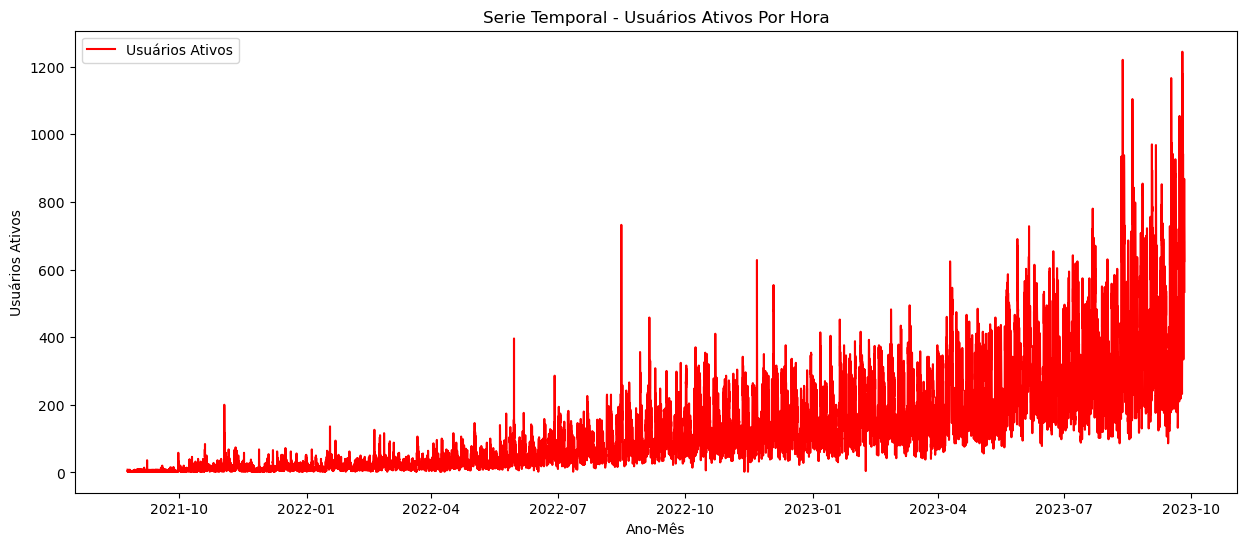

In [96]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal - Usuários Ativos Por Hora")
plt.plot(target, label = "Usuários Ativos", color = 'red')
plt.xlabel("Ano-Mês")
plt.ylabel("Usuários Ativos")
plt.legend(loc = "best")
plt.show();

#### Pre processing

In [97]:
data.shape

(18288, 1)

In [98]:
# Dividing data
data_train = data.iloc[0:16057]
data_valid = data.iloc[16058:]

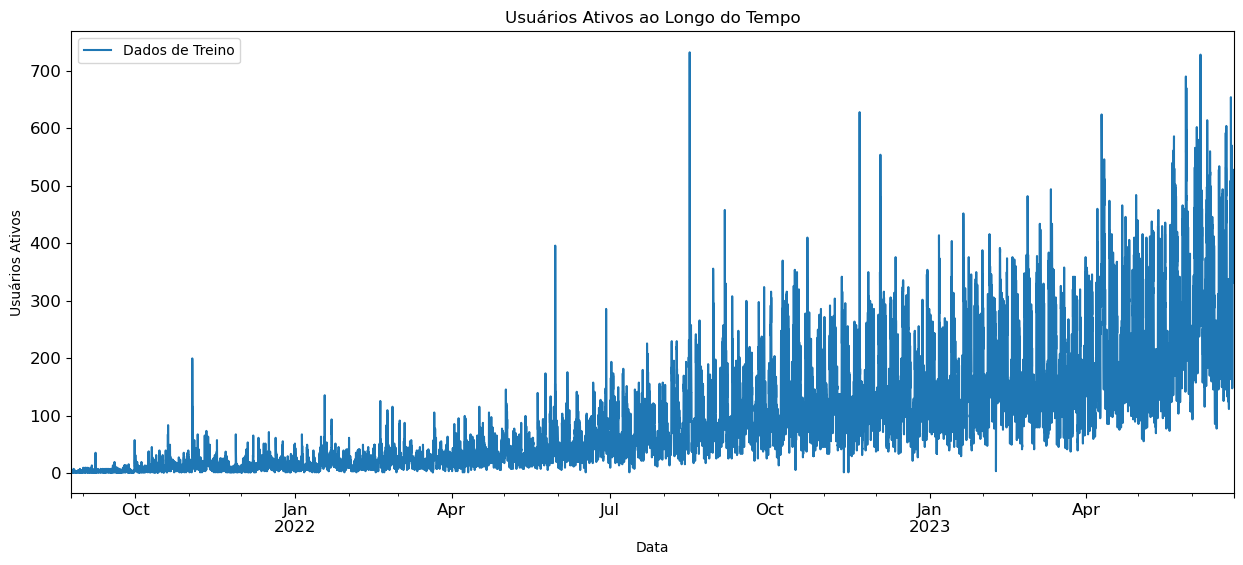

In [99]:
# Plot
figure(figsize = (15, 6))
data_train.usuarios_ativos.plot(title = 'Usuários Ativos ao Longo do Tempo', 
                               fontsize = 12, 
                               label = 'Dados de Treino') 
plt.xlabel("Data") 
plt.ylabel("Usuários Ativos") 
plt.legend(loc = 'best') 
plt.show()

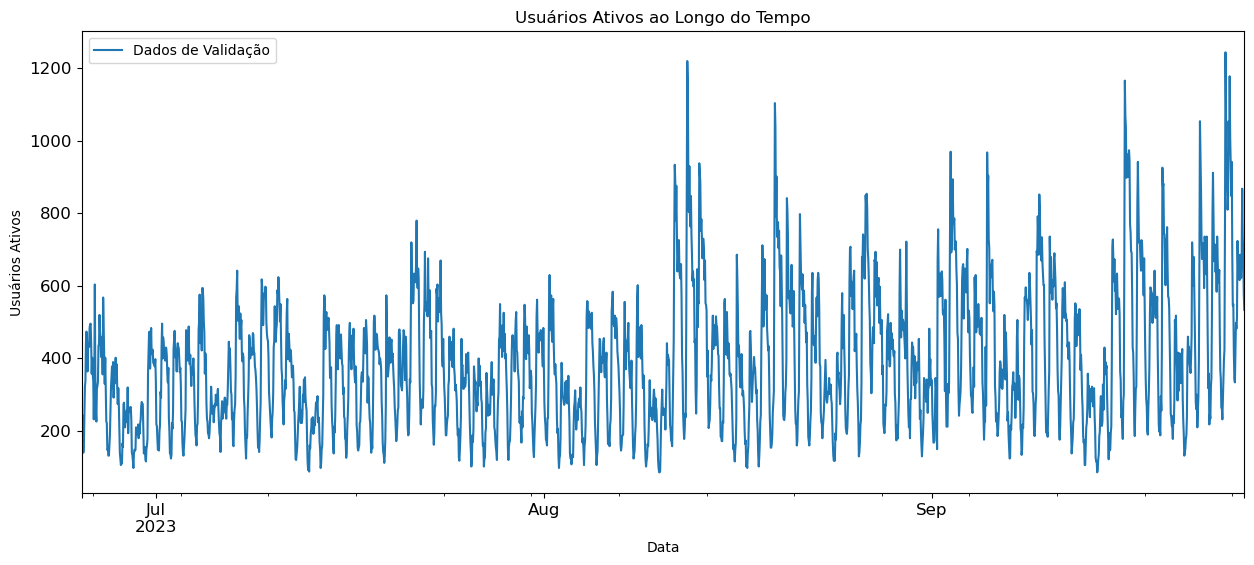

In [100]:
# Plot
figure(figsize = (15, 6))
data_valid.usuarios_ativos.plot(title = 'Usuários Ativos ao Longo do Tempo', 
                              fontsize = 12, 
                              label = 'Dados de Validação') 
plt.xlabel("Data") 
plt.ylabel("Usuários Ativos") 
plt.legend(loc = 'best') 
plt.show()

In [101]:
# Function to test stationarity
def stationarity_test(serie, window = 12, title='Rolling Statistics and Dickey-Fuller Test'):

    # Calculate rolling statistics
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot of rolling statistics
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Moving Average') 
    plt.plot(rolstd, color = 'black', label = 'Moving Standard Deviation')
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)

    # Dickey-Fuller Test
    print('\nDickey-Fuller Test Result:')
    dftest = adfuller(serie, autolag='AIC')
    dfout = pd.Series(dftest[0:4], index = ['Test Statistic',
                                            'p-Value',
                                            'Number of Lags Considered',
                                            'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfout['Critical Value (%s)' % key] = value

    print(dfout)

    # Conclusion based on p-value
    if dfout['p-Value'] > 0.05:
        print('\nConclusion:\nThe p-value is greater than 0.05 and therefore we have no evidence to reject the null hypothesis.\nThis series is probably not stationary.')
    else:
        print('\nConclusion:\nThe p-value is less than 0.05 and therefore we have evidence to reject the null hypothesis.\nThis series is probably stationary.')


<Figure size 1500x600 with 0 Axes>

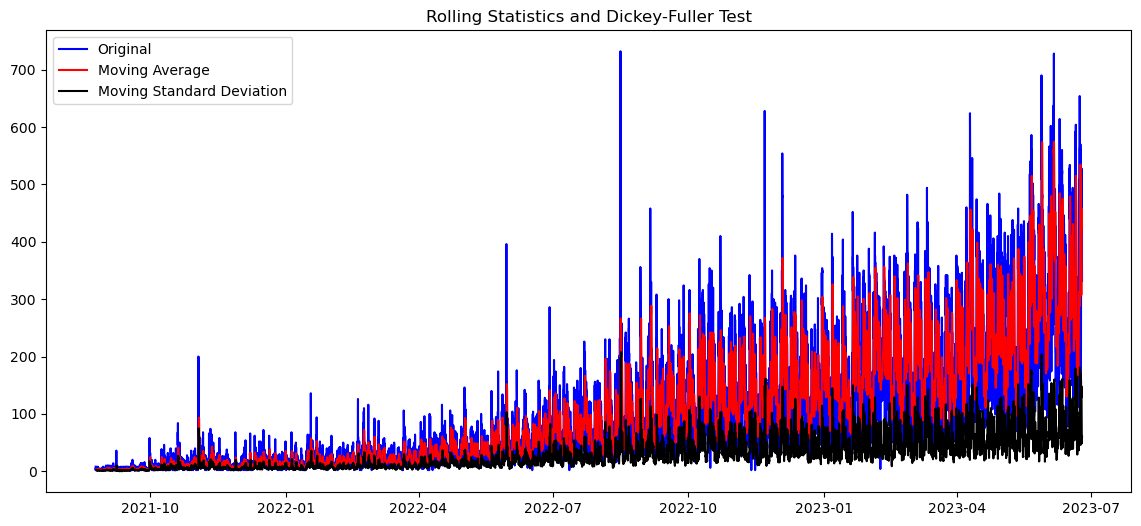


Dickey-Fuller Test Result:
Test Statistic                    -5.038033
p-Value                            0.000019
Number of Lags Considered         43.000000
Number of Observations Used    16013.000000
Critical Value (1%)               -3.430758
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64

Conclusion:
The p-value is less than 0.05 and therefore we have evidence to reject the null hypothesis.
This series is probably stationary.


In [102]:
figure(figsize = (15, 6))
stationarity_test(data_train)

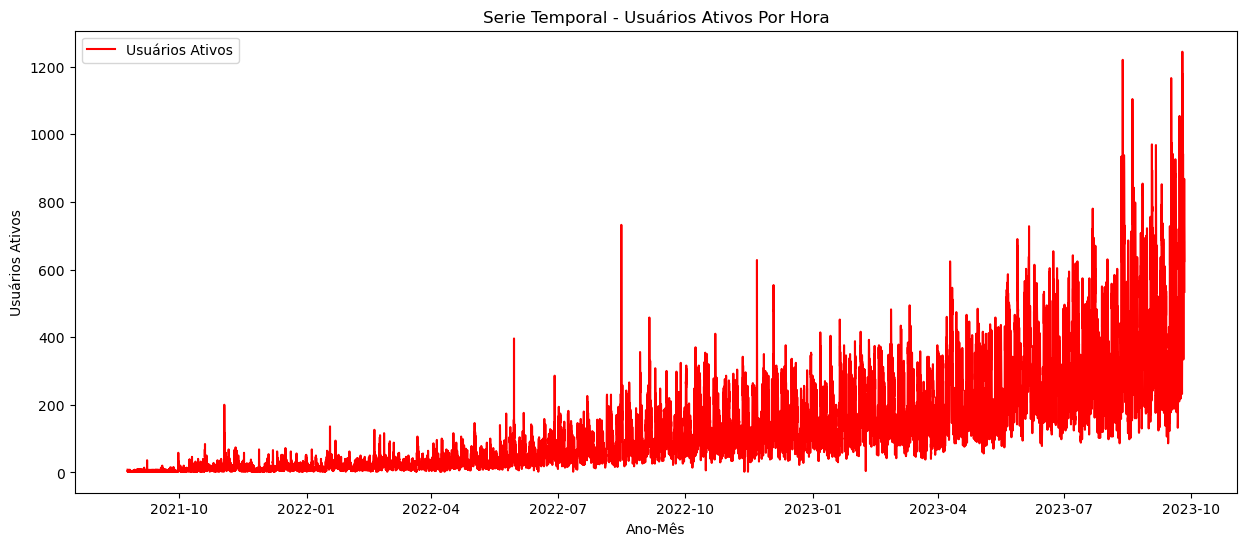

In [103]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal - Usuários Ativos Por Hora")
plt.plot(target, label = "Usuários Ativos", color = 'red')
plt.xlabel("Ano-Mês")
plt.ylabel("Usuários Ativos")
plt.legend(loc = "best")
plt.show();

#### Metodo Naive

Técnica de estimativa na qual os dados reais do último período são usados como previsão desse período, sem ajustá-los ou tentar estabelecer fatores causais. É usado apenas para comparação com as previsões geradas pelas melhores técnicas (sofisticadas).

Naive = ingênuo

In [104]:
type(data_train)

pandas.core.frame.DataFrame

In [105]:
data_train.head()

,usuarios_ativos
data,
2021-08-25 00:00:00,8
2021-08-25 01:00:00,2
2021-08-25 02:00:00,6
2021-08-25 03:00:00,2
2021-08-25 04:00:00,2


In [106]:
data_train.tail()

,usuarios_ativos
data,
2023-06-24 20:00:00,444
2023-06-24 21:00:00,406
2023-06-24 22:00:00,352
2023-06-24 23:00:00,390
2023-06-25 00:00:00,332


In [107]:
# Criando array com os valores da variável target em treino
array_usuarios_ativos_treino = np.asarray(data_train.usuarios_ativos)

In [108]:
type(array_usuarios_ativos_treino)

numpy.ndarray

In [109]:
array_usuarios_ativos_treino.shape

(16057,)

In [110]:
# Cria uma cópia dos dados de validação para usar na comparação dos dados reais com as previsões
data_valid_cp = data_valid.copy()

In [111]:
len(array_usuarios_ativos_treino)

16057

In [112]:
# Previsão. Método Naive!
data_valid_cp['previsao_naive'] = array_usuarios_ativos_treino[len(array_usuarios_ativos_treino) - 1] 

In [113]:
# Colocamos lado a lado, valor real e valor "previsto"
data_valid_cp[['usuarios_ativos', 'previsao_naive']].head()

,usuarios_ativos,previsao_naive
data,,
2023-06-25 02:00:00,218,332
2023-06-25 03:00:00,244,332
2023-06-25 04:00:00,168,332
2023-06-25 05:00:00,140,332
2023-06-25 06:00:00,156,332


In [114]:
# Colocamos lado a lado, valor real e valor "previsto"
data_valid_cp[['usuarios_ativos', 'previsao_naive']].tail()

,usuarios_ativos,previsao_naive
data,,
2023-09-25 19:00:00,868,332
2023-09-25 20:00:00,732,332
2023-09-25 21:00:00,702,332
2023-09-25 22:00:00,580,332
2023-09-25 23:00:00,534,332


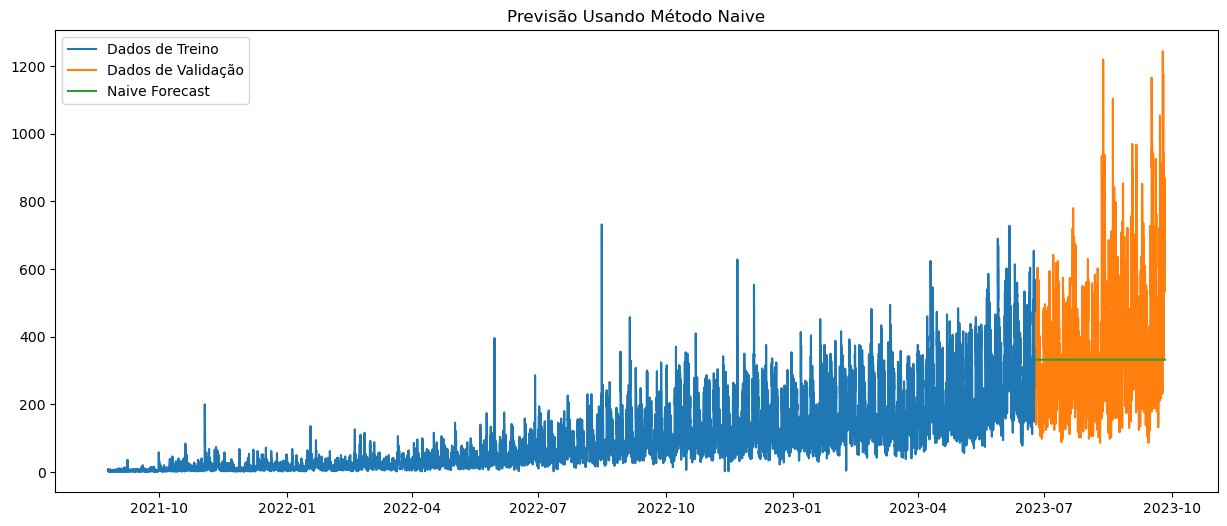

In [115]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(data_train.index, data_train['usuarios_ativos'], label = 'Dados de Treino') 
plt.plot(data_valid.index, data_valid['usuarios_ativos'], label = 'Dados de Validação') 
plt.plot(data_valid_cp.index, data_valid_cp['previsao_naive'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

Observe que a linha amarela segue uma linha horizontal, sem considerar o padrão de comportamento da série ao longo do tempo. 

Ou seja, a previsão seria apenas um valor geral considerando o último valor dos dados de treino (dados históricos).

Esse é um método muito simples, mas que serve como ponto de partida. Qualquer técnica mais avançada deve apresentar uma performance melhor.

In [116]:
# Define valor real e valor previsto
y_true = data_valid_cp.usuarios_ativos
y_pred = data_valid_cp.previsao_naive

In [117]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

195.06210118417584


RMSE é a taxa de erro e quanto menor, melhor!

#### Simple Exponential Smoothing

In [118]:
# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(array_usuarios_ativos_treino).fit(smoothing_level = 0.2, optimized = True)

In [119]:
# Previsões com o Modelo
data_valid['previsoes_v1'] = modelo_v1.forecast(len(data_valid)) 

In [120]:
# Colocamos lado a lado, valor real e valor "previsto"
data_valid[['usuarios_ativos', 'previsoes_v1']].head()

,usuarios_ativos,previsoes_v1
data,,
2023-06-25 02:00:00,218,395.388938
2023-06-25 03:00:00,244,395.388938
2023-06-25 04:00:00,168,395.388938
2023-06-25 05:00:00,140,395.388938
2023-06-25 06:00:00,156,395.388938


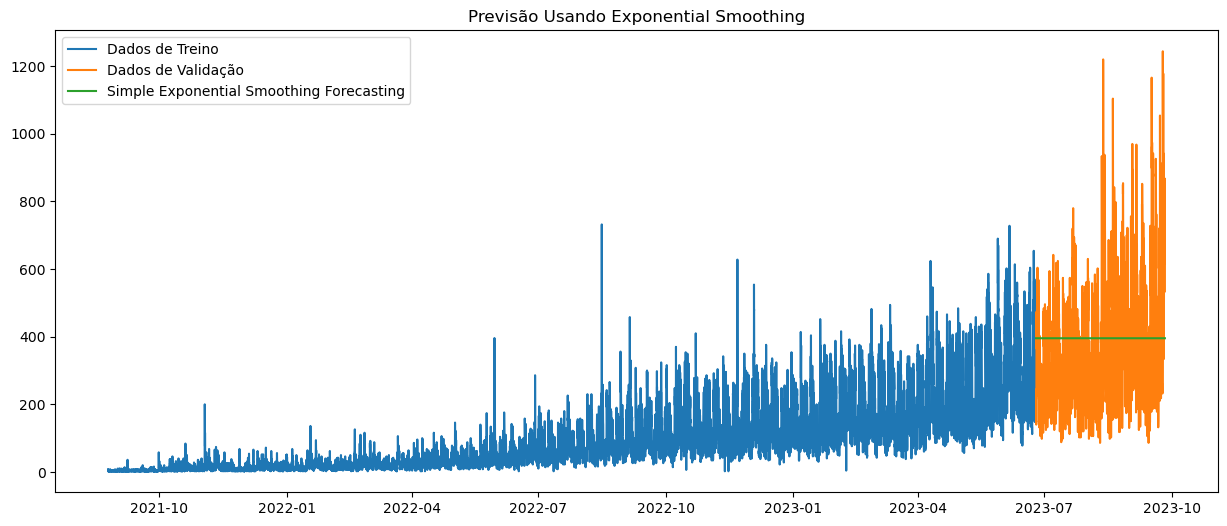

In [121]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(data_train['usuarios_ativos'], label = 'Dados de Treino')
plt.plot(data_valid['usuarios_ativos'], label = 'Dados de Validação')
plt.plot(data_valid['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [122]:
# Define valor real e valor previsto
y_true = data_valid.usuarios_ativos
y_pred = data_valid.previsoes_v1

In [123]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

186.52867297329848


Reduzimos o erro em relação ao modelo com método Naive. 
Será que conseguimos melhorar a performance do modelo? Vamos tentar outro tipo de suavização exponencial.

#### Double Exponential Smoothing 

In [124]:
# Vamos usar o Double. Como não temos sazonalidade na série, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
modelo_v2 = ExponentialSmoothing(np.asarray(data_train['usuarios_ativos']), 
                                 trend = 'additive').fit(smoothing_level = 0.9, 
                                                         optimized = True) 

In [125]:
# Previsões com o Modelo
data_valid.loc[:,'previsoes_v2'] = modelo_v2.forecast(len(data_valid))

In [126]:
# Colocamos lado a lado, valor real e valor "previsto"
data_valid[['usuarios_ativos', 'previsoes_v1', 'previsoes_v2']].head()

,usuarios_ativos,previsoes_v1,previsoes_v2
data,,,
2023-06-25 02:00:00,218,395.388938,337.500281
2023-06-25 03:00:00,244,395.388938,337.520836
2023-06-25 04:00:00,168,395.388938,337.541391
2023-06-25 05:00:00,140,395.388938,337.561946
2023-06-25 06:00:00,156,395.388938,337.582501


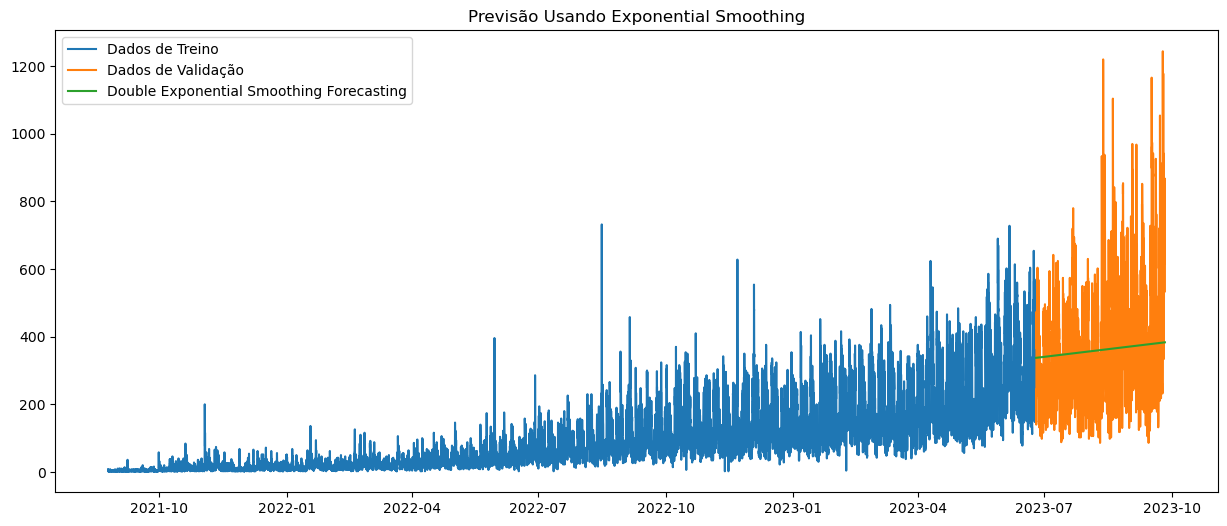

In [127]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(data_train['usuarios_ativos'], label = 'Dados de Treino')
plt.plot(data_valid['usuarios_ativos'], label = 'Dados de Validação')
plt.plot(data_valid['previsoes_v2'], label = 'Double Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [128]:
# Define valor real e valor previsto
y_true = data_valid.usuarios_ativos
y_pred = data_valid.previsoes_v2

In [129]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

185.04203015292674


A linha de previsão mudou, seguindo um pouco mais o padrão nos dados, e o erro do modelo caiu um pouco mais.

#### Modelagem Preditiva

In [131]:
data.head()

,usuarios_ativos
data,
2021-08-25 00:00:00,8
2021-08-25 01:00:00,2
2021-08-25 02:00:00,6
2021-08-25 03:00:00,2
2021-08-25 04:00:00,2


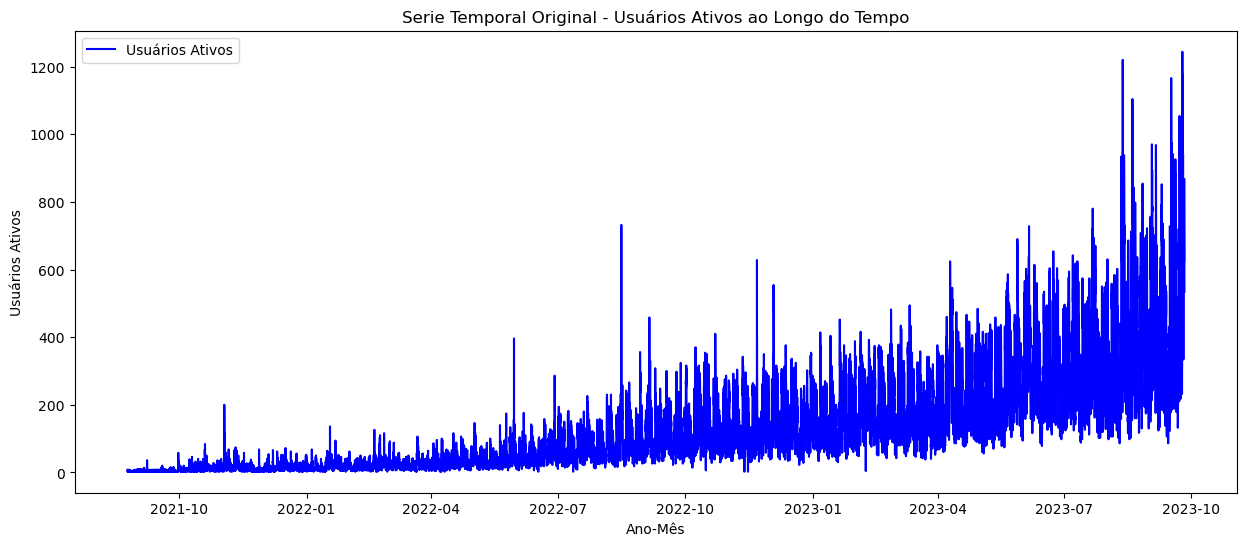

In [132]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal Original - Usuários Ativos ao Longo do Tempo")
plt.plot(target, label = "Usuários Ativos", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Usuários Ativos")
plt.legend(loc = "best")
plt.show();

In [133]:
data_train.shape

(16057, 1)

In [134]:
data_valid.shape

(2230, 3)

In [135]:
# Aplicando transformação de log (colocando os dados na mesma escala, o que é requerido pelos modelos ARIMA)
data_train_log = np.log(data_train['usuarios_ativos']) 

#### Modelo ARIMA

In [137]:
# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(data_train_log, order = (2, 1, 0), freq = 'H')

In [138]:
# Treinamento
modelo_v3 = modelo_AR.fit()  

In [139]:
# Dados Reais e Previsões (em treino)
data_real = data_train_log
previsoes_v3 = modelo_v3.fittedvalues

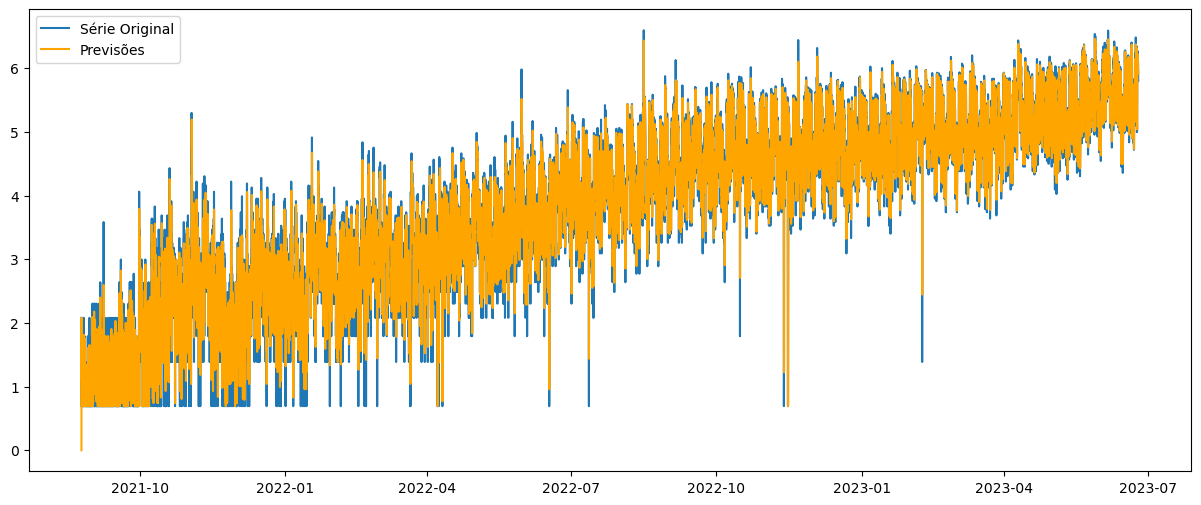

In [140]:
# Plot
figure(figsize = (15, 6))
plt.plot(data_real, label = 'Série Original') 
plt.plot(previsoes_v3, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [141]:
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        usuarios_ativos   No. Observations:                16057
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -8119.356
Date:                Mon, 28 Apr 2025   AIC                          16244.711
Time:                        15:06:06   BIC                          16267.763
Sample:                    08-25-2021   HQIC                         16252.334
                         - 06-25-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3419      0.005    -68.096      0.000      -0.352      -0.332
ar.L2         -0.0695      0.006    -11.737      0.000      -0.081      -0.058
sigma2         0.1610      0.001    158.760      0.000       0.159       0.163
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12378.93
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Modelo: ARIMA(2,1,0) indica que o modelo é um processo autorregressivo de segunda ordem (AR(2)) com uma diferenciação (I(1)) e sem parte de médias móveis (MA(0)).

Parâmetros AR:

- ar.L1: O coeficiente do primeiro termo autorregressivo é -0.3419, o que significa que há uma relação negativa entre o valor atual da série e o valor imediatamente anterior.
- ar.L2: O coeficiente do segundo termo autorregressivo é -0.0695, indicando uma relação negativa mais fraca com o segundo valor anterior.
- Variância do erro (sigma2): O valor de 0.1610 indica a variância dos erros do modelo. Quanto menor esse valor, melhor o ajuste do modelo aos dados.

Testes Estatísticos:

- Ljung-Box (Q): O teste Ljung-Box verifica a autocorrelação residual. Um valor de p (Prob(Q)) próximo de 1, como 0.95 aqui, sugere que não há evidências significativas de autocorrelação residual, indicando um bom ajuste do modelo.
- Jarque-Bera (JB): Este teste verifica a normalidade dos resíduos. Um valor de p (Prob(JB)) próximo de 0, como aqui, indica que os resíduos não são normalmente distribuídos. Isso pode ser uma preocupação e pode valer a pena investigar mais.
- Heteroskedasticity (H): Este teste verifica a homocedasticidade dos resíduos. Um valor de p (Prob(H)) próximo de 0 indica que há evidências de heterocedasticidade, o que significa que a variância dos resíduos não é constante ao longo do tempo.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 16244.711. Um valor menor indica um melhor ajuste do modelo, mas é usado principalmente para comparar modelos.
- BIC (Bayesian Information Criterion): 16267.763. Assim como o AIC, um valor menor indica um melhor ajuste e é usado para comparações entre modelos.
- HQIC (Hannan-Quinn Information Criterion): 16252.334. Mais uma medida para comparar modelos, com um valor menor indicando um melhor ajuste.

O modelo ARIMA(2,1,0) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. Isso pode afetar as previsões do modelo e a interpretação dos intervalos de confiança. Pode ser útil investigar transformações dos dados, adicionar variáveis exógenas ou considerar modelos alternativos para melhorar o ajuste.

#### Previsões com dados de validação

In [142]:
data_valid_log = np.log(data_valid['usuarios_ativos'])

In [144]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
data_previsoes_v3 = modelo_v3.forecast(len(data_valid_log), alpha = 0.05) 

In [145]:
data_previsoes_v3.shape

(2230,)

In [146]:
data_previsoes_v3.head()

2023-06-25 01:00:00    5.853056
2023-06-25 02:00:00    5.847868
2023-06-25 03:00:00    5.846309
2023-06-25 04:00:00    5.847203
2023-06-25 05:00:00    5.847006
Freq: h, Name: predicted_mean, dtype: float64

In [147]:
# Criamos a série para o gráfico
fc_series = pd.Series(data_previsoes_v3, index = data_valid_log.index)

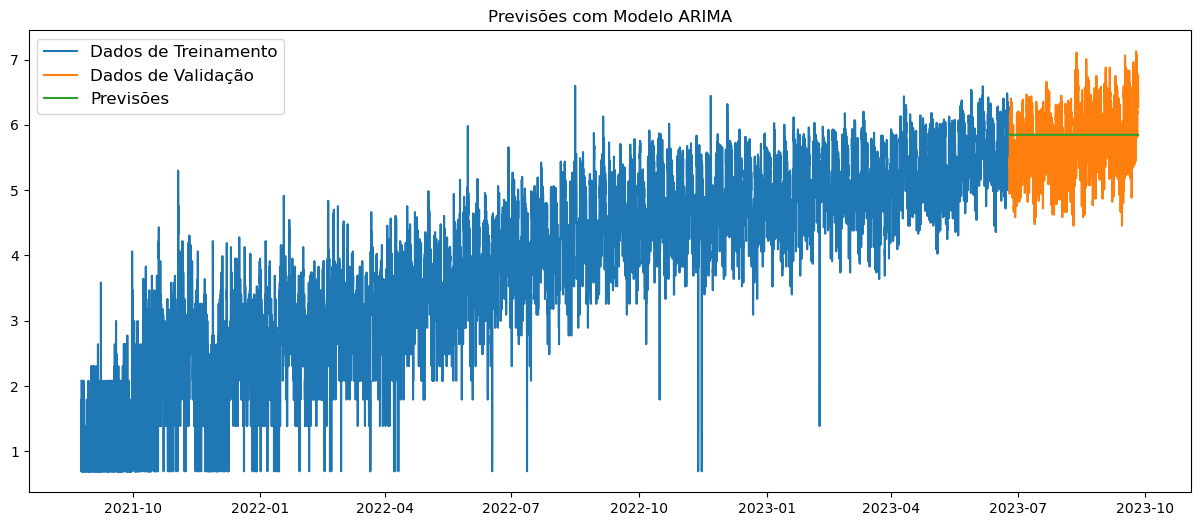

In [148]:
# Plot
figure(figsize = (15, 6))
plt.plot(data_train_log, label = 'Dados de Treinamento')
plt.plot(data_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [149]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [150]:
# Define valor real e valor previsto
y_true = data_valid_log
y_pred = fc_series

In [151]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.5136328974916268


Reduzimos de forma considerável o erro do nosso modelo. 

#### Modelo SARIMAX

In [152]:
# Cria o modelo
modelo_SARIMAX = SARIMAX(data_train_log, trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,12))

In [153]:
# Treinamento do modelo
modelo_v4 = modelo_SARIMAX.fit(disp = True)

In [154]:
# Dados Reais e Previsões (em treino)
data_real = data_train_log
previsoes_v4 = modelo_v4.fittedvalues

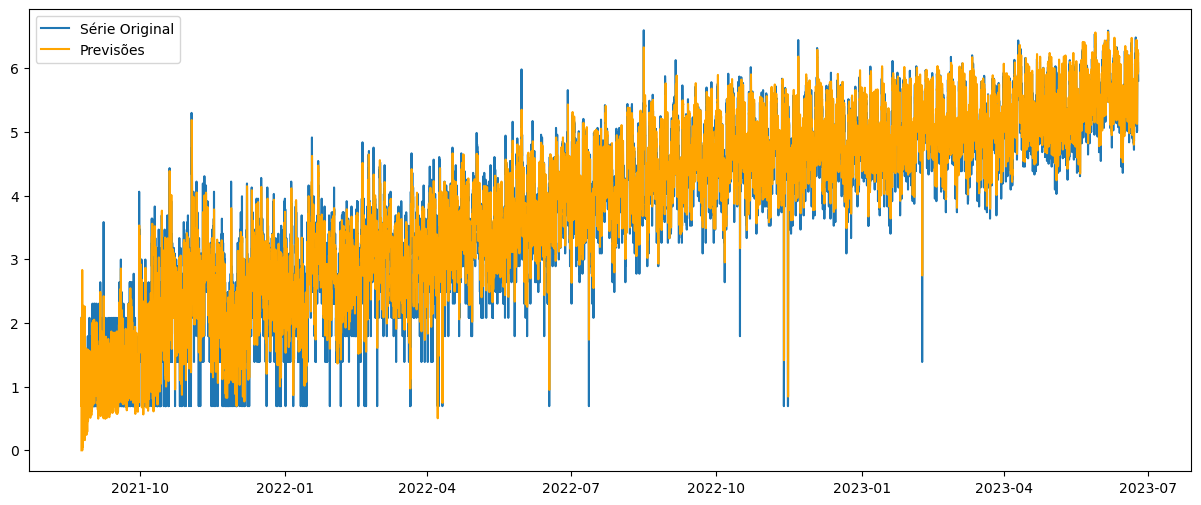

In [155]:
# Plot
figure(figsize = (15, 6))
plt.plot(data_real, label = 'Série Original') 
plt.plot(previsoes_v4, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [156]:
# Sumário do Modelo 
modelo_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      usuarios_ativos   No. Observations:                16057
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -7380.094
Date:                              Mon, 28 Apr 2025   AIC                          14776.188
Time:                                      15:13:38   BIC                          14837.652
Sample:                                  08-25-2021   HQIC                         14796.514
                                       - 06-25-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.005    -85.102      0.000      -0.427      -0.408
ar.L2         -0.1444      0.006    -22.494      0.000      -0.157      -0.132
ar.L3         -0.0446      0.007     -6.651      0.000      -0.058      -0.031
ar.L4         -0.0097      0.006     -1.584      0.113      -0.022       0.002
ar.L5          0.0146      0.006      2.400      0.016       0.003       0.027
ar.L6         -0.0011      0.006     -0.177      0.859      -0.013       0.011
ma.S.L12      -0.9965      0.001   -985.431      0.000      -0.998      -0.995
sigma2         0.1464      0.001    158.158      0.000       0.145       0.148
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15818.10
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Este modelo SARIMAX (Seasonal AutoRegressive Integrated Moving-Average with eXogenous variables) é um modelo de série temporal que inclui componentes sazonais. O modelo especificado é SARIMAX(6, 1, 0)x(0, 1, [1], 12), o que significa:

Parte não sazonal (ARIMA):

- AR(6): Processo autorregressivo de ordem 6.
- I(1): Diferenciação de primeira ordem.
- MA(0): Sem parte de médias móveis.

Parte sazonal:

- SAR(0): Sem componente autorregressivo sazonal.
- SI(1): Diferenciação sazonal de ordem 1.
- SMA(1): Média móvel sazonal de ordem 1.
- Período sazonal: 12 (indicando sazonalidade anual, presumivelmente mensal).

Aqui está uma interpretação dos resultados:

- Parâmetros AR: Os coeficientes dos termos autorregressivos (ar.L1 a ar.L6) mostram a relação entre o valor atual da série e seus valores anteriores. Por exemplo, o coeficiente ar.L1 é -0.4178, indicando uma relação negativa forte com o valor anterior.

- Parâmetro MA sazonal (ma.S.L12): O coeficiente de -0.9965 é muito próximo de -1, indicando uma forte relação negativa com o erro do termo sazonal anterior.

- Variância do erro (sigma2): O valor de 0.1464 indica a variância dos erros do modelo.

Testes Estatísticos:

- Ljung-Box (Q): Um valor de p (Prob(Q)) próximo de 1, como 0.99 aqui, sugere que não há evidências significativas de autocorrelação residual.
- Jarque-Bera (JB): Um valor de p (Prob(JB)) próximo de 0 indica que os resíduos não são normalmente distribuídos.
- Heteroskedasticity (H): Um valor de p (Prob(H)) próximo de 0 indica evidências de heterocedasticidade.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 14776.188. Usado para comparar modelos, com um valor menor indicando um melhor ajuste.
- BIC (Bayesian Information Criterion): 14837.652. Semelhante ao AIC, um valor menor indica um melhor ajuste.
- HQIC (Hannan-Quinn Information Criterion): 14796.514. Outra medida para comparar modelos.

O modelo SARIMAX(6,1,0)x(0,1,[1],12) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. A forte componente de média móvel sazonal indica uma relação significativa com os erros sazonais anteriores. Seria útil investigar a transformação dos dados ou a inclusão de variáveis exógenas para melhorar a normalidade dos resíduos e a homocedasticidade.

In [157]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
data_previsoes_v4 = modelo_v4.forecast(len(data_valid_log), alpha = 0.05) 

In [158]:
data_previsoes_v4.shape

(2230,)

In [159]:
# Cria a série para o gráfico
fc_series = pd.Series(data_previsoes_v4, index = data_valid_log.index)

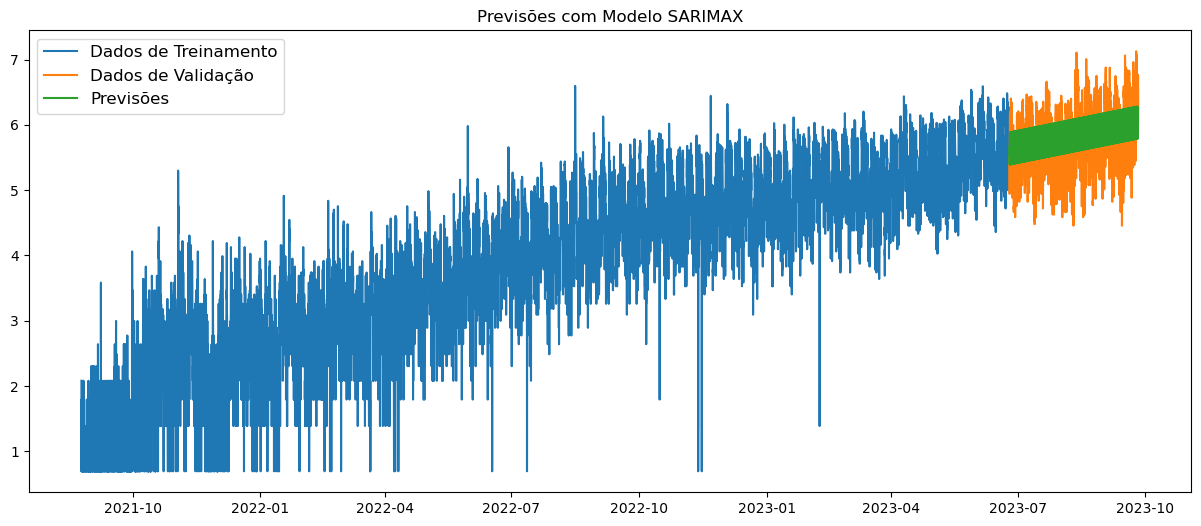

In [160]:
# Plot
figure(figsize = (15, 6))
plt.plot(data_train_log, label = 'Dados de Treinamento')
plt.plot(data_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [161]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [162]:
# Define valor real e valor previsto
y_true = data_valid_log
y_pred = fc_series

In [163]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.4634358184397439


Chegamos à melhor versão do nosso modelo. Vamos usá-lo para fazer as previsões com novos dados.

#### Previsão com Novos Dados

In [164]:
data_new.head()

,id,data
0,18288,26-09-2023 00:00
1,18289,26-09-2023 01:00
2,18290,26-09-2023 02:00
3,18291,26-09-2023 03:00
4,18292,26-09-2023 04:00


In [165]:
data_new.dtypes

id       int64
data    object
dtype: object

In [166]:
# Converte a coluna data para o tipo correto
data_new['data'] = pd.to_datetime(data_new.data, format = '%d-%m-%Y %H:%M')

In [167]:
data_new.dtypes

id               int64
data    datetime64[ns]
dtype: object

In [168]:
# Definimos o índice do dataset
data_new.index = data_new['data']

In [169]:
data_new.head()

,id,data
data,,
2023-09-26 00:00:00,18288,2023-09-26 00:00:00
2023-09-26 01:00:00,18289,2023-09-26 01:00:00
2023-09-26 02:00:00,18290,2023-09-26 02:00:00
2023-09-26 03:00:00,18291,2023-09-26 03:00:00
2023-09-26 04:00:00,18292,2023-09-26 04:00:00


In [170]:
# Vamos fazer a previsão para uma janela de 30 horas
previsoes = modelo_v4.predict(start = data_new.data[0], 
                              end = data_new.data[30], 
                              dynamic = False)

In [171]:
type(previsoes)

pandas.core.series.Series

In [172]:
previsoes[1:30]

2023-09-26 01:00:00    6.106393
2023-09-26 02:00:00    6.053870
2023-09-26 03:00:00    5.958813
2023-09-26 04:00:00    5.854540
2023-09-26 05:00:00    5.790876
2023-09-26 06:00:00    5.837193
2023-09-26 07:00:00    5.936014
2023-09-26 08:00:00    6.011391
2023-09-26 09:00:00    6.109127
2023-09-26 10:00:00    6.256549
2023-09-26 11:00:00    6.284607
2023-09-26 12:00:00    6.256198
2023-09-26 13:00:00    6.108544
2023-09-26 14:00:00    6.056022
2023-09-26 15:00:00    5.960965
2023-09-26 16:00:00    5.856691
2023-09-26 17:00:00    5.793028
2023-09-26 18:00:00    5.839344
2023-09-26 19:00:00    5.938166
2023-09-26 20:00:00    6.013543
2023-09-26 21:00:00    6.111278
2023-09-26 22:00:00    6.258700
2023-09-26 23:00:00    6.286759
2023-09-27 00:00:00    6.258350
2023-09-27 01:00:00    6.110696
2023-09-27 02:00:00    6.058173
2023-09-27 03:00:00    5.963116
2023-09-27 04:00:00    5.858843
2023-09-27 05:00:00    5.795179
Freq: h, Name: predicted_mean, dtype: float64

Como o modelo foi treinado com dados que receberam transformação de log, precisamos calcular a inversa da transformação para extrair as previsões na mesma unidade da série temporal.

In [173]:
# Inversa da transformação de log
np.exp(previsoes[1:30])

2023-09-26 01:00:00    448.717134
2023-09-26 02:00:00    425.757680
2023-09-26 03:00:00    387.150463
2023-09-26 04:00:00    348.814323
2023-09-26 05:00:00    327.299707
2023-09-26 06:00:00    342.815569
2023-09-26 07:00:00    378.423571
2023-09-26 08:00:00    408.050666
2023-09-26 09:00:00    449.945548
2023-09-26 10:00:00    521.416326
2023-09-26 11:00:00    536.253621
2023-09-26 12:00:00    521.233656
2023-09-26 13:00:00    449.683580
2023-09-26 14:00:00    426.674675
2023-09-26 15:00:00    387.984306
2023-09-26 16:00:00    349.565598
2023-09-26 17:00:00    328.004643
2023-09-26 18:00:00    343.553924
2023-09-26 19:00:00    379.238618
2023-09-26 20:00:00    408.929524
2023-09-26 21:00:00    450.914638
2023-09-26 22:00:00    522.539351
2023-09-26 23:00:00    537.408601
2023-09-27 00:00:00    522.356287
2023-09-27 01:00:00    450.652106
2023-09-27 02:00:00    427.593645
2023-09-27 03:00:00    388.819945
2023-09-27 04:00:00    350.318491
2023-09-27 05:00:00    328.711099
Freq: h, Name:

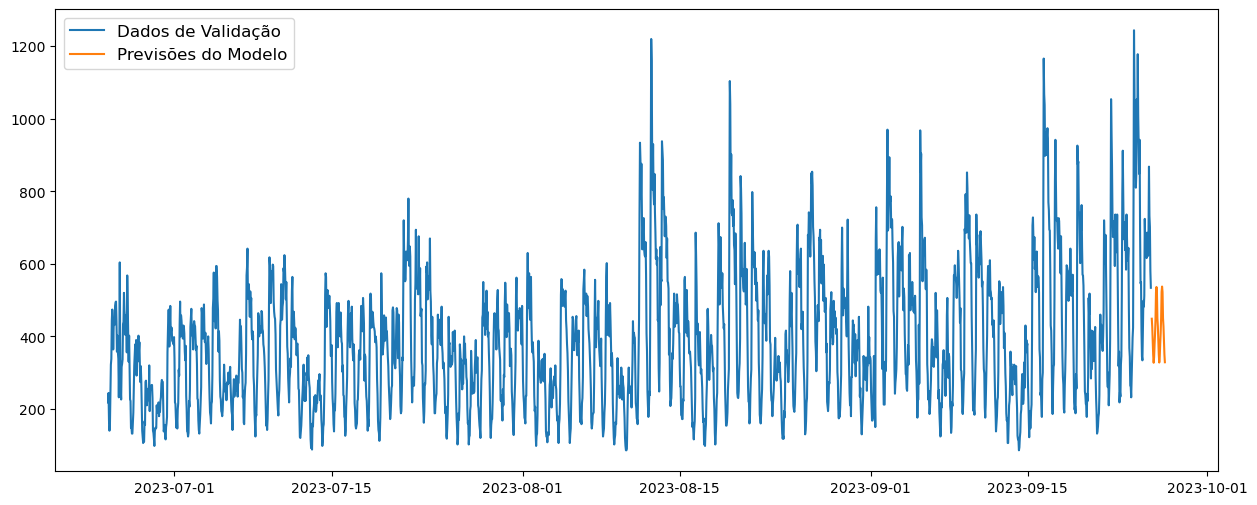

In [179]:
# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(data_valid['usuarios_ativos'], label = 'Dados de Validação')
plt.plot(np.exp(previsoes[1:30]), label = 'Previsões do Modelo')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [180]:
# Buscar as últimas 120 horas dos dados de validação
data_valid_ultimas_120_horas = data_valid.tail(120)

In [181]:
data_valid_ultimas_120_horas.head()

,usuarios_ativos,previsoes_v1,previsoes_v2
data,,,
2023-09-21 00:00:00,426,395.388938,380.871419
2023-09-21 01:00:00,288,395.388938,380.891974
2023-09-21 02:00:00,228,395.388938,380.912529
2023-09-21 03:00:00,190,395.388938,380.933084
2023-09-21 04:00:00,132,395.388938,380.953639


In [182]:
data_valid_ultimas_120_horas.tail()

,usuarios_ativos,previsoes_v1,previsoes_v2
data,,,
2023-09-25 19:00:00,868,395.388938,383.235248
2023-09-25 20:00:00,732,395.388938,383.255803
2023-09-25 21:00:00,702,395.388938,383.276359
2023-09-25 22:00:00,580,395.388938,383.296914
2023-09-25 23:00:00,534,395.388938,383.317469


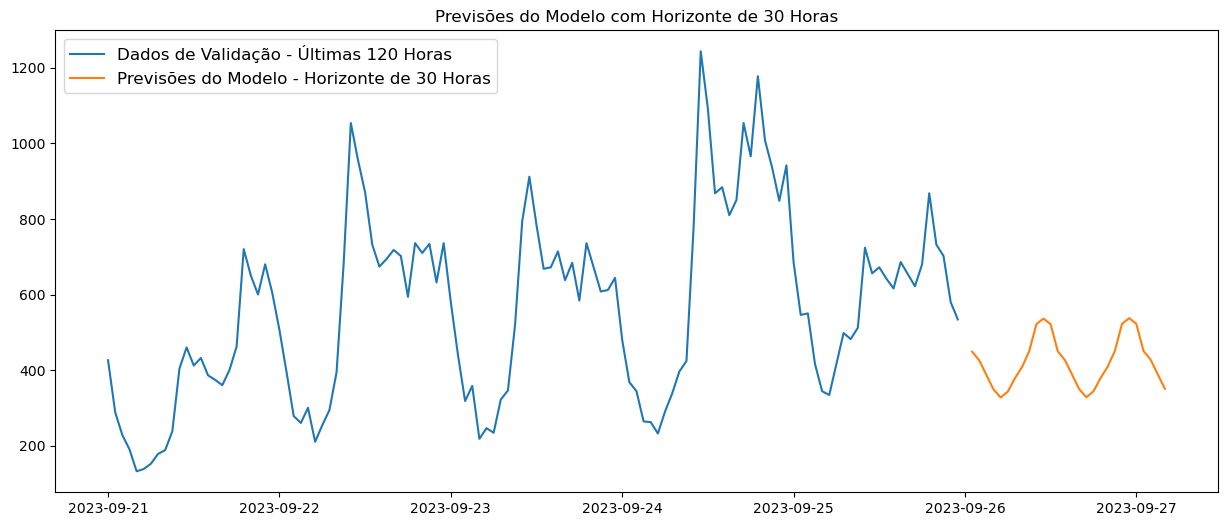

In [183]:
# Criamos uma nova série para as previsões com o índice correto
# O índice deve começar imediatamente após o último índice de df_valid_ultimas_120_horas
inicio_previsoes = data_valid_ultimas_120_horas.index[-1] + pd.Timedelta(hours = 1)
indice_previsoes = pd.date_range(start = inicio_previsoes, periods = len(previsoes[1:30]), freq = 'H')
previsoes_series = pd.Series(np.exp(previsoes[1:30]), index = indice_previsoes)

# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(data_valid_ultimas_120_horas['usuarios_ativos'], label = 'Dados de Validação - Últimas 120 Horas')
plt.plot(previsoes_series, label='Previsões do Modelo - Horizonte de 30 Horas')
plt.title('Previsões do Modelo com Horizonte de 30 Horas')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show();